## Librerías

In [30]:
# Manejo de datos
import pandas as pd
from sklearn.model_selection import train_test_split

# Clasificador arboles de decision
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Metricas
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics

# Feature importance
from sklearn.ensemble import ExtraTreesClassifier

# Visualizacion 
from sklearn import tree #La versión que tengo es 0.24.1 y está disponible apartir de la 0.21
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Funcion propia
from funciones import CargarPandasDatasetCategoricos

# Manejo de warnings
import warnings
warnings.filterwarnings('ignore')

## Cargar datos

In [19]:
data = CargarPandasDatasetCategoricos("datasets/endirehCat.csv")

### Random forest no usan datos categóricos (object type), para ello obtengo One Hot Encoding con la instruccion pd.get_dummies de pandas para las columnas categóricas

Etiqueta de salida y la descarto del conjunto de datos

In [20]:
data = data.drop(columns = ["P9_8", "P1_2", "P1_2_A", "P9_3"])
data = pd.get_dummies(data)

data_num = pd.read_csv('datasets/endirehCat.csv', usecols=["P1_2", "P1_2_A", "P9_3"])
x = pd.concat([data, data_num], axis=1)

y = pd.read_csv('datasets/endirehCat.csv', usecols=["P9_8"])

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Definimos los árboles

In [22]:
modelo1 = DecisionTreeClassifier(criterion         =  "entropy",
                                min_samples_leaf  =  100,
                                min_samples_split = 335,
                                random_state      = 5)

modelo2 = DecisionTreeClassifier(criterion         =  "gini",
                                min_samples_leaf  =  90,
                                min_samples_split = 380,
                                random_state      = 5)

### Entrenamos

In [23]:
%%time
modelo1 = modelo1.fit(x_train, y_train)

CPU times: user 845 ms, sys: 67.5 ms, total: 913 ms
Wall time: 912 ms


In [24]:
%%time
modelo2 = modelo2.fit(x_train, y_train)

CPU times: user 858 ms, sys: 59.4 ms, total: 917 ms
Wall time: 916 ms


In [25]:
modelo1.classes_, modelo2.classes_

(array(['Abuso y violencia', 'Abuso y violencia y atencion no autorizada',
        'Atencion no autorizada'], dtype=object),
 array(['Abuso y violencia', 'Abuso y violencia y atencion no autorizada',
        'Atencion no autorizada'], dtype=object))

### Predecimos los de prueba

In [26]:
predictions1 = modelo1.predict(x_test)
predictions2 = modelo2.predict(x_test)

### Obtenemos accuracy

In [28]:
sklearn.metrics.f1_score(y_test, predictions1, average='micro'), sklearn.metrics.f1_score(y_test, predictions2, average='micro')

(0.5278528934559221, 0.5305570578691184)

### Obtenemos matriz de confusión

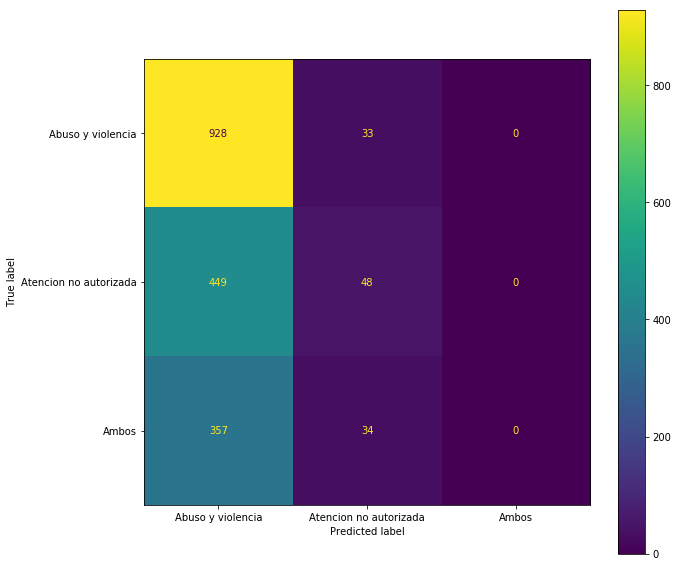

In [11]:
class_names = ['Abuso y violencia', 'Atencion no autorizada', 'Ambos']

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(modelo1, x_test, y_test, display_labels=class_names, ax=ax)
plt.show()

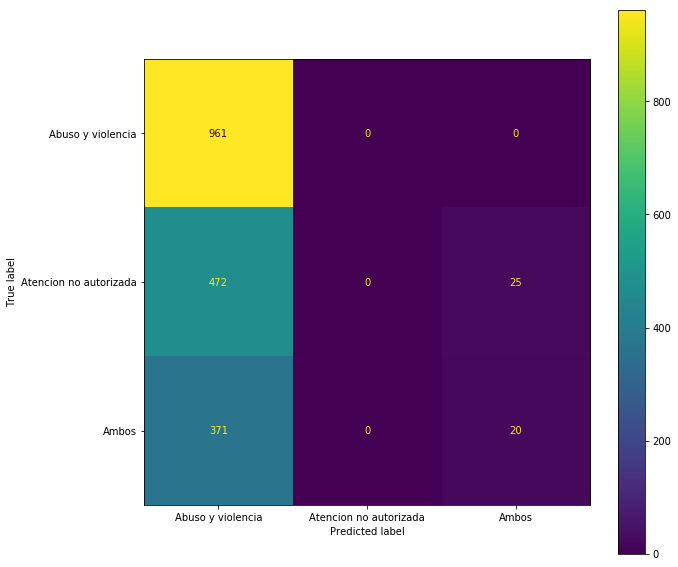

In [12]:
class_names = ['Abuso y violencia', 'Atencion no autorizada', 'Ambos']

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(modelo2, x_test, y_test, display_labels=class_names, ax=ax)
plt.show()

### Visualizacion del árbol

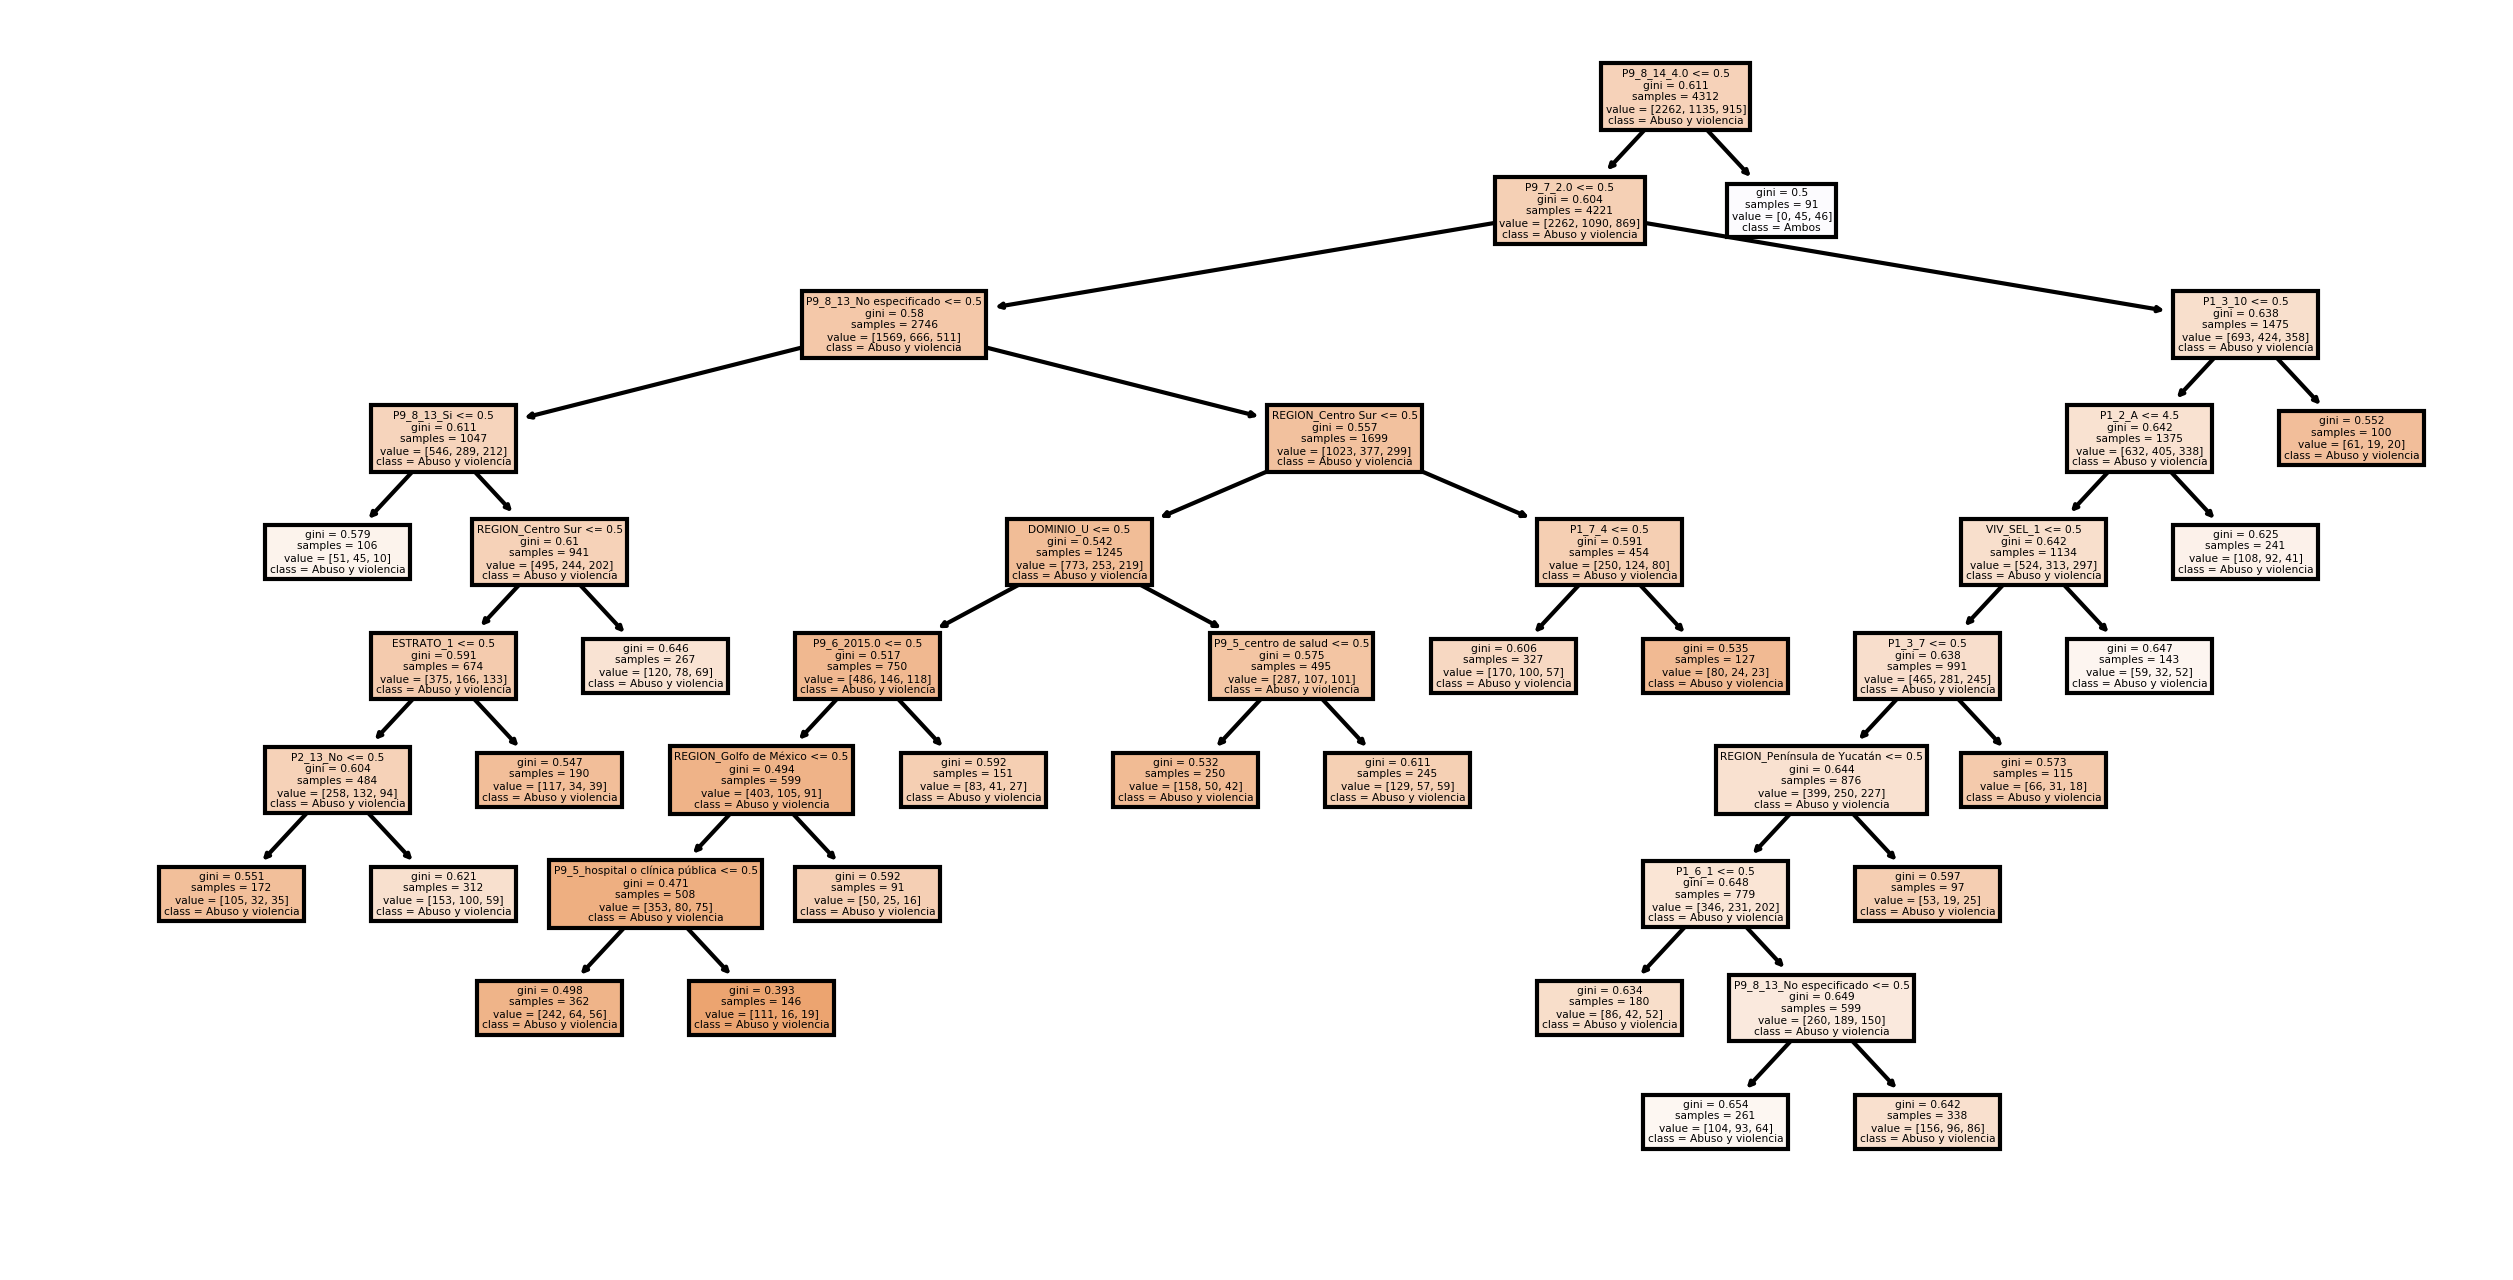

In [13]:
fn = x.columns
cn = ['Abuso y violencia', 'Atencion no autorizada', 'Ambos']
fig, axes = plt.subplots(nrows = 1,
                         ncols = 1, 
                         figsize = (10, 5),
                         dpi=300)
tree.plot_tree(modelo2,
               feature_names = fn, 
               class_names=cn,
               filled = True);
#fig.savefig('imagename.png')

### Visualizar la importancia de cada viriable

## Grid search

'Micro' is Calculate metrics globally by counting the total true positives, false negatives and false positives.

In [33]:
f1_scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average='micro')

In [34]:
%%time
param = {'criterion':['entropy', 'gini'],
         'splitter':['best', 'random'],
         'max_features':['sqrt','log2',None],
         'random_state':[5,42,666,None],
         'min_samples_split': range(330, 401, 10),
         'min_samples_leaf':range(20, 50, 7)
        }

classifier=GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
                        n_jobs=-1,
                        verbose=2,
                        scoring=f1_scorer,
                        param_grid=param)


classifier=classifier.fit(x_train, y_train)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
CPU times: user 2min 25s, sys: 5.71 s, total: 2min 31s
Wall time: 49min 47s


In [35]:
classifier.best_params_

{'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_leaf': 41,
 'min_samples_split': 350,
 'random_state': None,
 'splitter': 'best'}

In [39]:
predictions=classifier.best_estimator_.predict(x_test)
sklearn.metrics.f1_score(y_test, predictions, average='micro')

0.5197404002163332

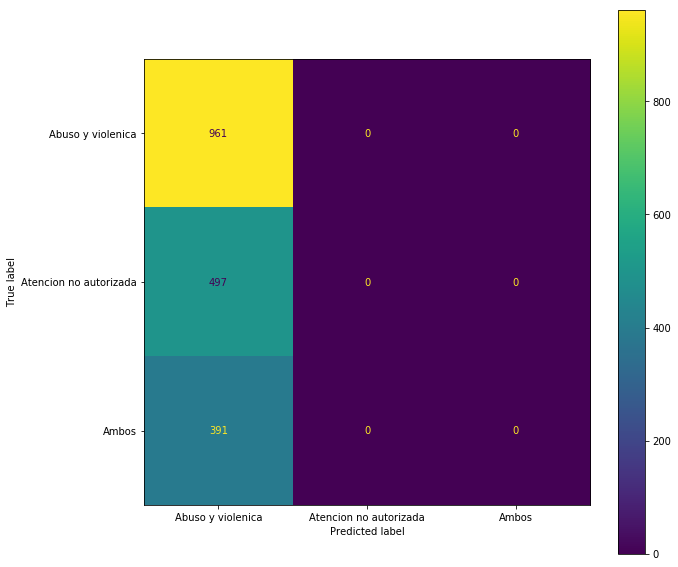

In [37]:
class_names = ['Abuso y violenica', 'Atencion no autorizada', 'Ambos']

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(classifier.best_estimator_, x_test, y_test, display_labels=class_names, ax=ax)
plt.show()

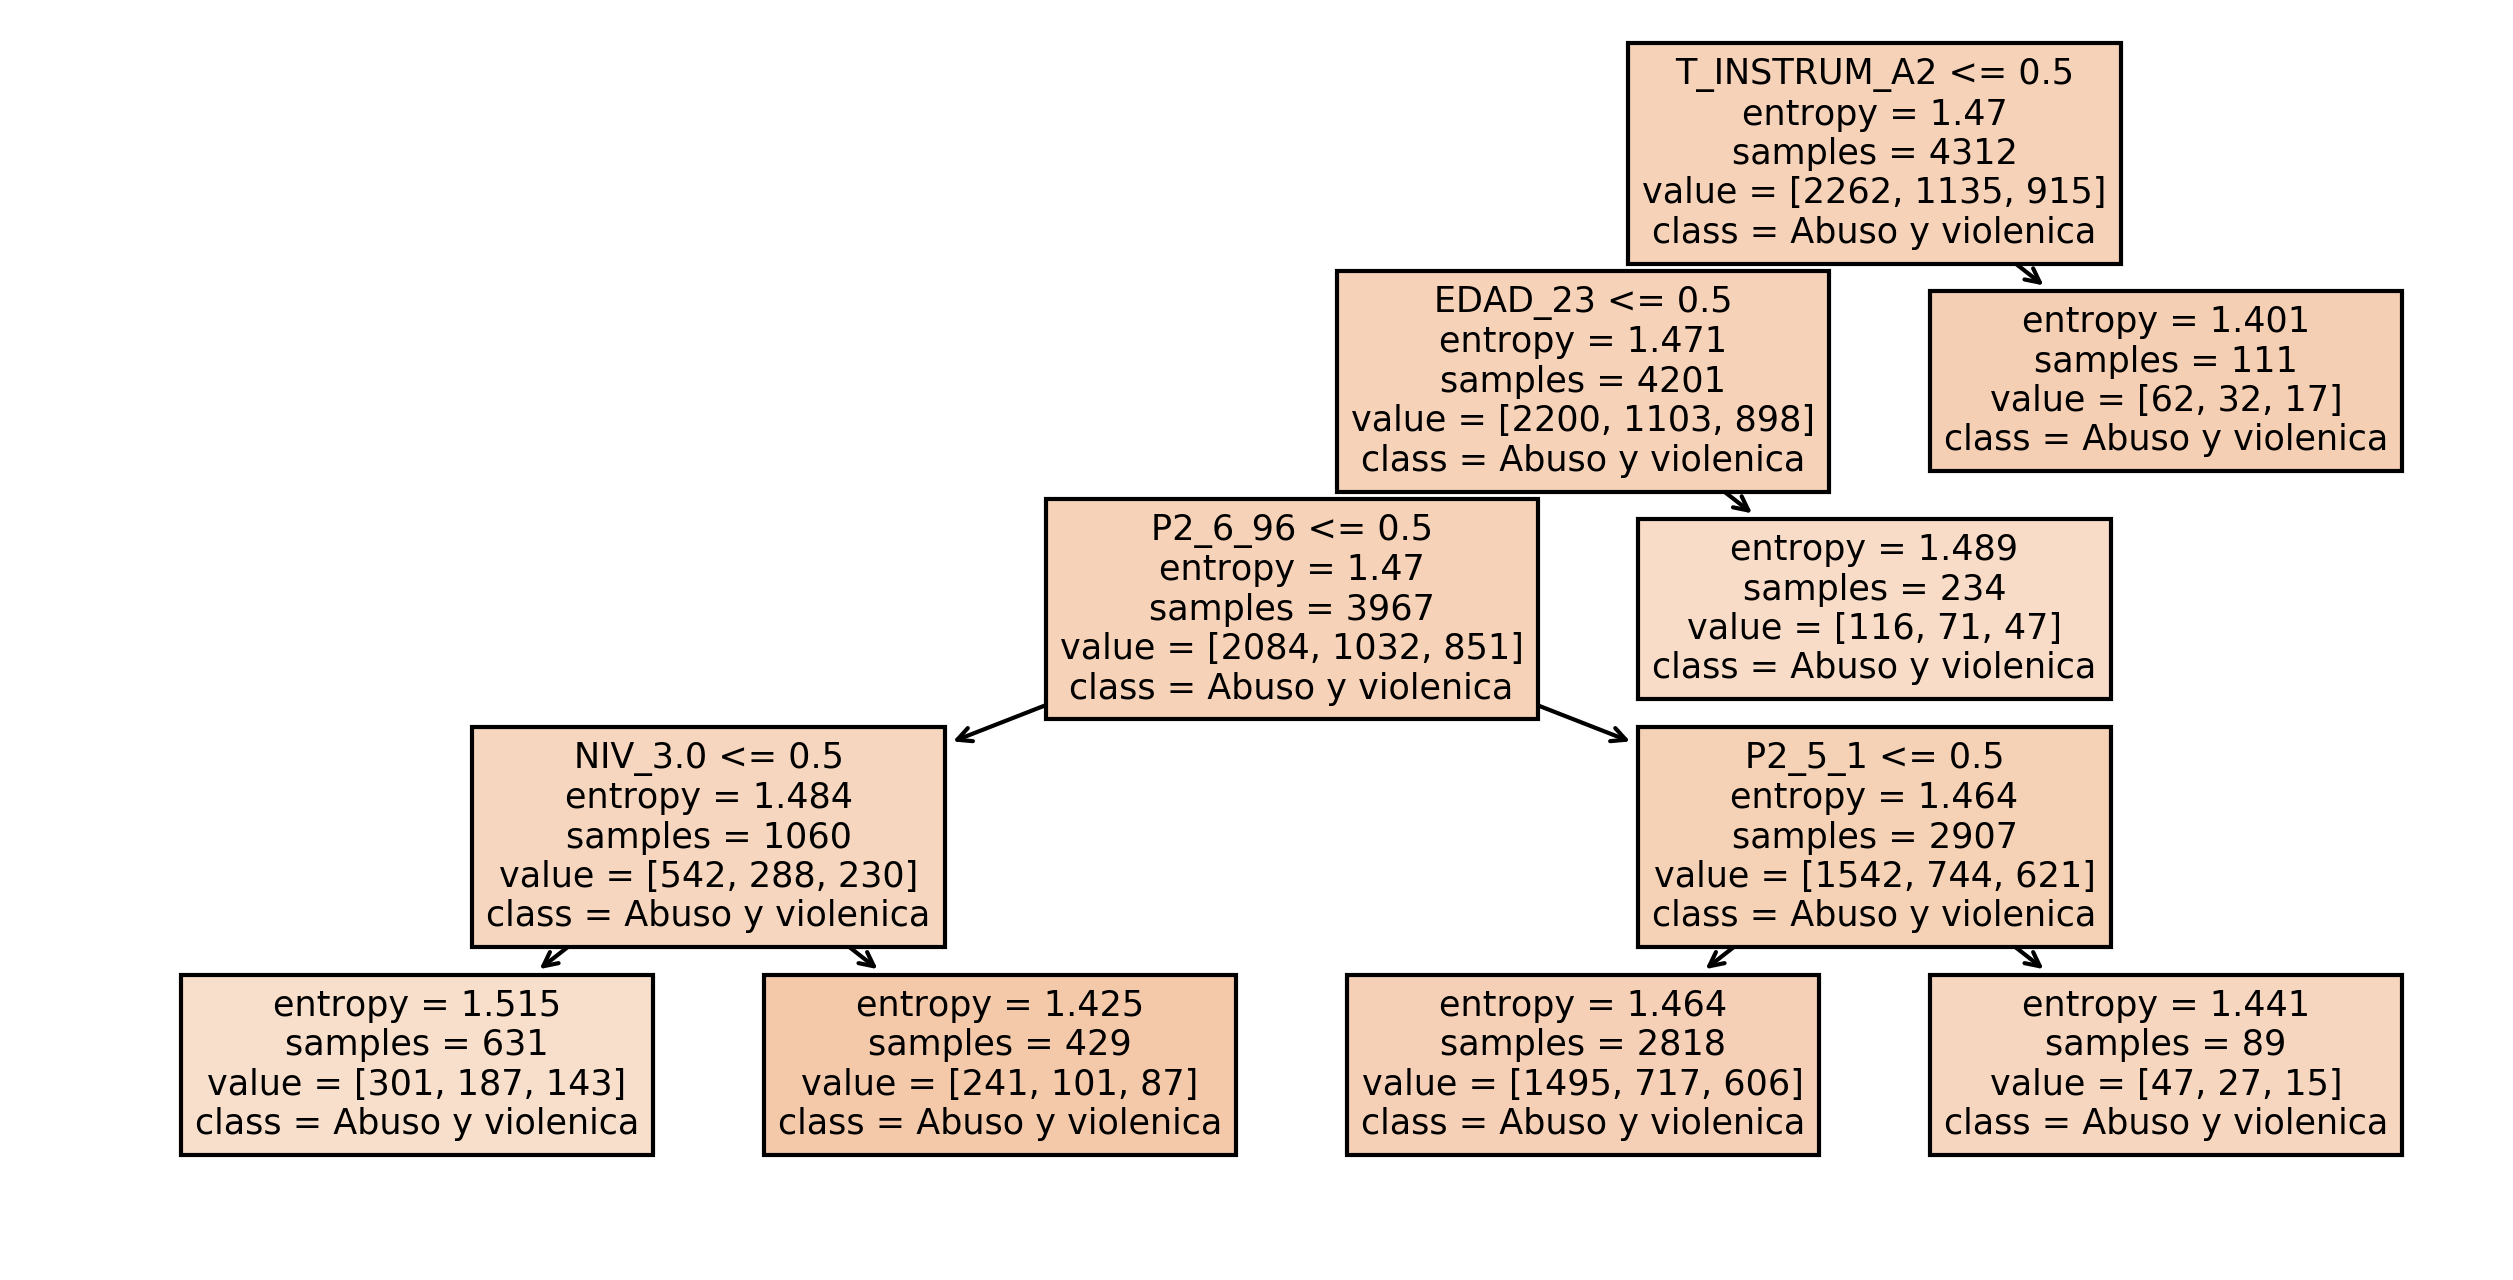

In [38]:
fn = x.columns
cn = ['Abuso y violenica', 'Atencion no autorizada', 'Ambos']
fig, axes = plt.subplots(nrows = 1,
                         ncols = 1, 
                         figsize = (10, 5),
                         dpi=300)
tree.plot_tree(classifier.best_estimator_,
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('3catOHEbaseline.png')

In [41]:
aux = CargarPandasDatasetCategoricos("datasets/endirehCat.csv")

In [52]:
aux["P9_8"].value_counts()/aux["P9_8"].value_counts().sum()

Abuso y violencia                             0.523129
Abuso y violencia y atencion no autorizada    0.264892
Atencion no autorizada                        0.211979
Name: P9_8, dtype: float64

In [54]:
data.columns

Index(['ID_VIV_1000009.05', 'ID_VIV_1000060.02', 'ID_VIV_1000088.04',
       'ID_VIV_1000088.05', 'ID_VIV_1000102.04', 'ID_VIV_1000173.04',
       'ID_VIV_1000232.04', 'ID_VIV_1000252.05', 'ID_VIV_1000256.02',
       'ID_VIV_1000279.02',
       ...
       'P9_8_11_No', 'P9_8_11_Si', 'P9_8_13_No', 'P9_8_13_No especificado',
       'P9_8_13_Si', 'P9_8_14_1.0', 'P9_8_14_2.0', 'P9_8_14_3.0',
       'P9_8_14_4.0', 'P9_8_14_No especificado'],
      dtype='object', length=18851)

### Visualizar la importancia de cada viriable